In [154]:
import os
from pathlib import Path
PARENT_PATH = Path(os.getcwd()).parent.absolute()
import pandas as pd

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections


import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [155]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [156]:
# load data
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls,'Requirements List')

In [157]:
# data shape
df.shape

(10232, 13)

In [158]:
# data preprocess
df1 = df[df['Mapped to a standard?'] != 'No mapping']
df1.reset_index(drop=True, inplace=True)
df1['Standard mapping?'].replace('\n',',', regex=True,inplace = True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.replace(r'^[\s,]+|[\s,]+$|(\s)*(,)[\s,]*', r'\2\1', regex=True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.split(',')

In [159]:
n = df1.shape[0]
for i in range(n):
    for j in range(len(df1['Standard mapping?'][i])):
        if df1['Standard mapping?'][i][j].lower() == 'vmp':
            df1['Standard mapping?'][i][j] = 'VMP'

# number of samples by category

In [160]:
df2 = df1.copy()

In [161]:
labels_dict = {}
for i in range(df2.shape[0]):
    for j in range(len(df2['Standard mapping?'][i])):
        label = df2['Standard mapping?'][i][j].strip()
        if label == '':
            continue
        if label not in list(labels_dict.keys()):
            labels_dict[label] = 1
        else:
            labels_dict[label] += 1

In [162]:
sorted_dict = dict(sorted(labels_dict.items(), key=lambda item: item[1]))

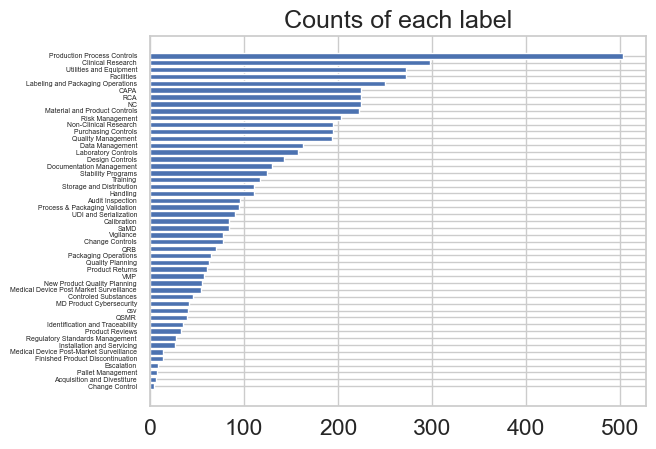

In [163]:
import matplotlib.pyplot as plt

names = list(sorted_dict.keys())
values = list(sorted_dict.values())

plt.barh(range(len(labels_dict)), values, tick_label=names)
plt.yticks(fontsize=5)
plt.title('Counts of each label')
plt.show()

# word frequency analysis

In [164]:
# extract all the words from text, not including numbers
df3 = df2.copy()
for i in range(df3.shape[0]):
    df3['Text'][i] = " ".join(re.sub("([^A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    #df3['Text'][i] = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    df3['Text'][i] = df3['Text'][i].lower().split()
    words = df3['Text'][i]   

In [165]:
# exclude all the stop_words including 'shall'
stop_words = set(stopwords.words('english'))
df3['Text'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in df3['Text']]
df3['Text'] = [[word for word in tweet_words if word != 'shall']
              for tweet_words in df3['Text']]

In [166]:
texts = df3['Text']
all_words = list(itertools.chain(*texts))
counts_words = collections.Counter(all_words)
counts_words.most_common(15)

[('quality', 2243),
 ('product', 1661),
 ('control', 1308),
 ('device', 1248),
 ('data', 1127),
 ('products', 1110),
 ('materials', 991),
 ('management', 983),
 ('system', 968),
 ('procedures', 866),
 ('appropriate', 865),
 ('requirements', 864),
 ('production', 863),
 ('manufacturer', 859),
 ('process', 856)]

Text(0.5, 1.0, 'Common Words Found in Texts (Without Stop Words)')

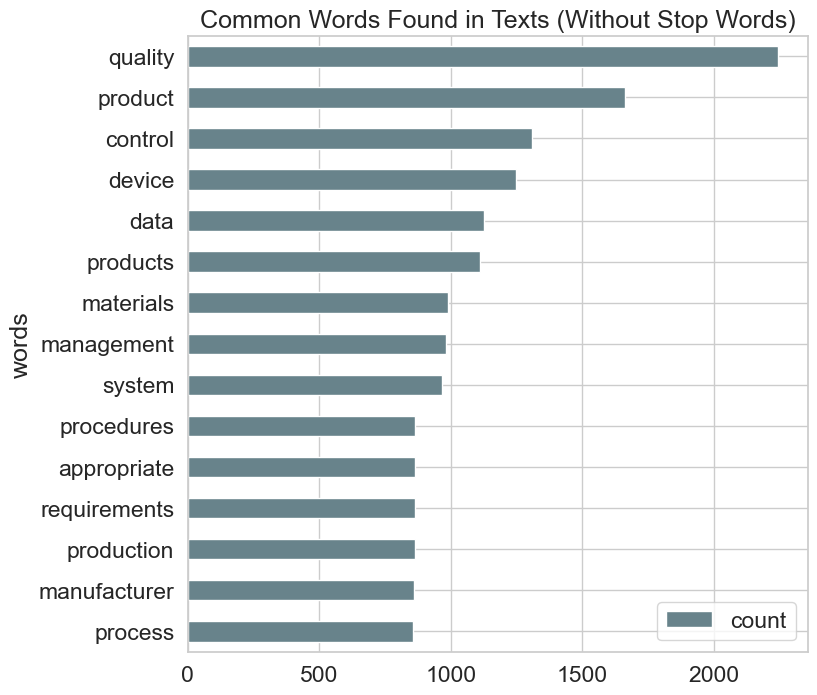

In [167]:
clean_texts = pd.DataFrame(counts_words.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_texts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="#68838B")
ax.set_title("Common Words Found in Texts (Without Stop Words)")


# sentence length analysis

In [168]:
names = list(sorted_dict.keys())
values = list(sorted_dict.values())

In [169]:
lengths = []
counts = []
for name in names:
    count = 0
    length = 0
    for i in range(len(df2['Text'])):
        if name in df2['Standard mapping?'][i]:
            count += 1
            length += len(df2['Text'][i])
    counts.append(count)
    lengths.append(length)          

In [170]:
avg_len = []
for i in range(len(names)):
    if counts[i] == 0:
        print(counts[i])
        avg_len.append(0)
    else:
        avg_len.append(round(lengths[i]/counts[i],2))

In [171]:
data_tuples = list(zip(names,avg_len))
df_len = pd.DataFrame(data_tuples, columns=['labels','avg_len'])

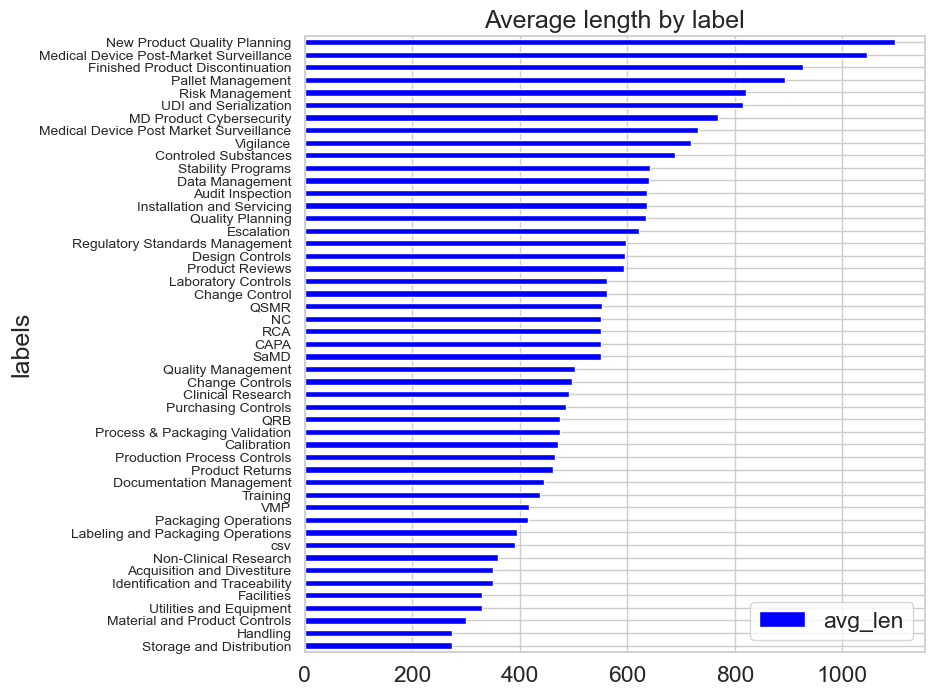

In [172]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_len.sort_values(by='avg_len').plot.barh(x='labels',y='avg_len',ax=ax,
                                         color="blue")
ax.set_title("Average length by label")
ax.yaxis.set_tick_params(labelsize=10)

# distribution of length

In [173]:
df4 = df3.copy()
text_length = []
for i in range(len(df4['Text'])):
    text_length.append(len(df4['Text'][i]))
df4['Text_length'] = text_length

Text(0, 0.5, 'Counts')

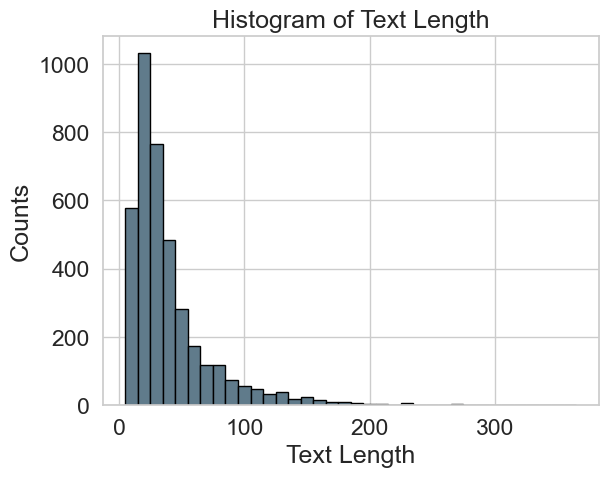

In [174]:
# matplotlib histogram
plt.hist(df4['Text_length'], color = '#607B8B', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Counts')
